In [20]:
# import relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

In [2]:
# load the data

ec_df = pd.read_csv(r"/Users/adityamxr/Desktop/Electricity Demand Projection Project/data/Electricity Consumption.csv")

In [3]:
# verify import 

ec_df.head()

,DATE,Electricty_Consumption_in_TW
0,1/1/1973,35.9728
1,2/1/1973,36.1334
2,3/1/1973,35.0625
3,4/1/1973,33.8416
4,5/1/1973,33.5107


### Basic EDA

In [4]:
# check dataframe info
ec_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DATE                          561 non-null    object 
 1   Electricty_Consumption_in_TW  561 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.9+ KB


**No nulls present**

In [5]:
ec_df['DATE'] = ec_df['DATE'].astype(str)  # ensure it's treated as a string before cleaning
ec_df['DATE'] = ec_df['DATE'].str.strip()  # remove any leading or trailing spaces

In [8]:
# convert date column to datetime64ns

# try converting the DATE column again without specifying the format
ec_df['DATE'] = pd.to_datetime(ec_df['DATE'], errors='coerce')

# check if the conversion worked and if there are any NaT values left
print('Number of NaT values: ', ec_df['DATE'].isnull().sum()) 

# drop any rows where DATE conversion failed (if NaT values exist)
ec_df = ec_df.dropna(subset=['DATE'])

# set the DATE column as the index for time series analysis
ec_df.set_index('DATE', inplace=True)

# check the first few rows to confirm the changes
print(ec_df.head())

Number of NaT values:  0
            Electricty_Consumption_in_TW
DATE                                    
1973-01-01                       35.9728
1973-02-01                       36.1334
1973-03-01                       35.0625
1973-04-01                       33.8416
1973-05-01                       33.5107


#### Plot the data to visualize the time series components.

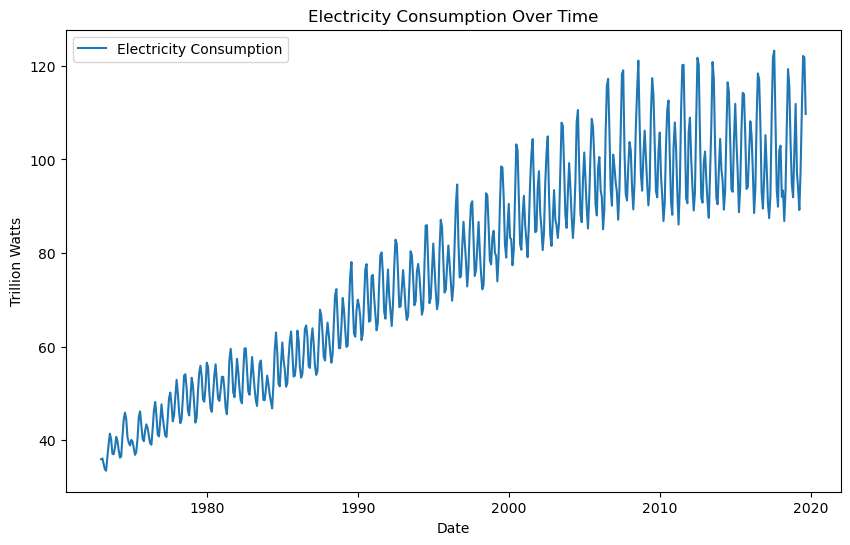

In [9]:
# plotting the electricity consumption over time
plt.figure(figsize=(10, 6))
plt.plot(ec_df['Electricty_Consumption_in_TW'], label='Electricity Consumption')
plt.title('Electricity Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Trillion Watts')
plt.legend()
plt.show()

**There is a clear upward Trend, as well as a clear seasonal component to the time series.**

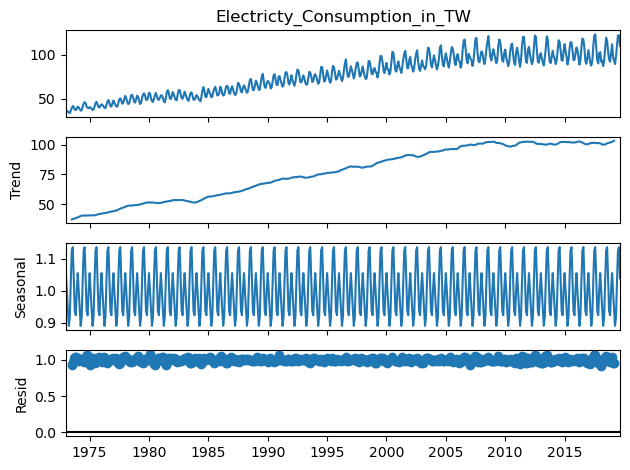

In [10]:
# decompose the time series
decomp = seasonal_decompose(ec_df['Electricty_Consumption_in_TW'], model = 'multiplicative')

# plot the decomposition

decomp.plot()
plt.show()

### **Stationary Check using ADFuller Test**

- Null Hypothesis: time series is non-stationary, meaning it has a trend and that its mean and variance change over time.
- Alternative Hypothesis: time series is stationary, meaning its mean and variance dont change over time.

In [12]:
# perform the Augmented Dickey-Fuller test
result = adfuller(ec_df['Electricty_Consumption_in_TW'])

# extract the ADF statistic and the p-value
adf_stat = result[0]
p_value = result[1]

# print the ADF statistic and p-value
print(f'ADF Statistic: {adf_stat}')
print(f'p-value: {p_value}')


if p_value < 0.05:
    print("The time series is stationary (Reject the null hypothesis).")
else:
    print("The time series is non-stationary (Fail to reject the null hypothesis).")

ADF Statistic: -1.740593372983245
p-value: 0.4103281604468676
The time series is non-stationary (Fail to reject the null hypothesis).


**Time series is non-stationary, so making it stationary before running the SARIMA model is appropriate.**

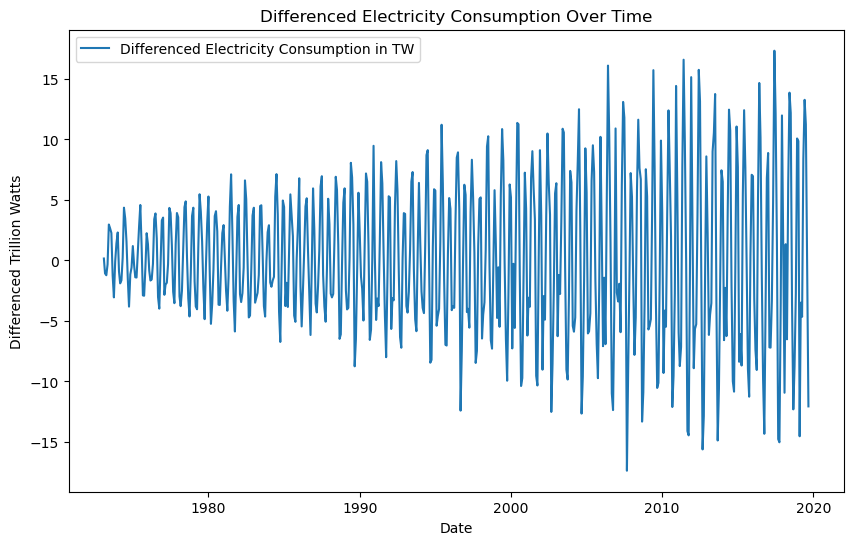

In [13]:
# use first order differencing to make the time series stationary

ec_df_diff = ec_df['Electricty_Consumption_in_TW'].diff().dropna()

# plot the differenced series

plt.figure(figsize=(10, 6))
plt.plot(ec_df_diff, label='Differenced Electricity Consumption in TW')
plt.title('Differenced Electricity Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Trillion Watts')
plt.legend()
plt.show()

In [14]:
# re-run the ADF test on the differenced series
result_diff = adfuller(ec_df_diff)

# extract and print the ADF statistic and p-value
print(f'ADF Statistic (Differenced): {result_diff[0]}')
print(f'p-value (Differenced): {result_diff[1]}')

# interpretation based on the p-value
if result_diff[1] < 0.05:
    print("The differenced time series is stationary (Reject the null hypothesis).")
else:
    print("The differenced time series is still non-stationary (Fail to reject the null hypothesis).")

ADF Statistic (Differenced): -7.941665363981165
p-value (Differenced): 3.301343802151855e-12
The differenced time series is stationary (Reject the null hypothesis).


**Time series is stationary, perform auto-arima to find the best parameters.**

In [15]:
# fit the seasonal ARIMA model to the stationary series

sarima = auto_arima(ec_df['Electricty_Consumption_in_TW'], 
                   seasonal=True, m= 12, # m = 12 is monthly seasonality
                   trace= True,
                   suppress_warnings=True
                   )

# print model summary
print(sarima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2349.108, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3661.148, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3094.486, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3659.390, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=2350.424, Time=2.54 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=3.84 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=2828.097, Time=0.26 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=2.11 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=2386.131, Time=2.75 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=2351.661, Time=2.70 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=2293.568, Time=0.88 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=2

In [16]:
# split data into train and test sets (using the last 24 months as the test set)
train_data = ec_df['Electricty_Consumption_in_TW'][:-24]
test_data = ec_df['Electricty_Consumption_in_TW'][-24:]

In [17]:
# forecast for the next 24 months (2 years)
sarima = SARIMAX(train_data, order=(1,1,3), seasonal_order=(1,0,2,12)).fit()

forecast = sarima.get_forecast(steps=24)

# get the predicted mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# create a future index for the forecasted values
future_dates = pd.date_range(start='2020-01-01', periods=24, freq='M')
forecast_df = pd.DataFrame({'Forecast': forecast_mean}, index=future_dates)

/Users/adityamxr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/adityamxr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/adityamxr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.60536D+01    |proj g|=  4.40219D+01

At iterate    5    f=  3.14212D+00    |proj g|=  4.57980D-01

At iterate   10    f=  2.58421D+00    |proj g|=  1.87095D-01

At iterate   15    f=  2.08761D+00    |proj g|=  1.93405D-01

At iterate   20    f=  2.00108D+00    |proj g|=  9.12928D-03

At iterate   25    f=  1.99765D+00    |proj g|=  5.06663D-02

At iterate   30    f=  1.99286D+00    |proj g|=  5.28653D-03

At iterate   35    f=  1.99273D+00    |proj g|=  4.65282D-04

At iterate   40    f=  1.99262D+00    |proj g|=  8.86377D-03

At iterate   45    f=  1.99253D+00    |proj g|=  4.84422D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

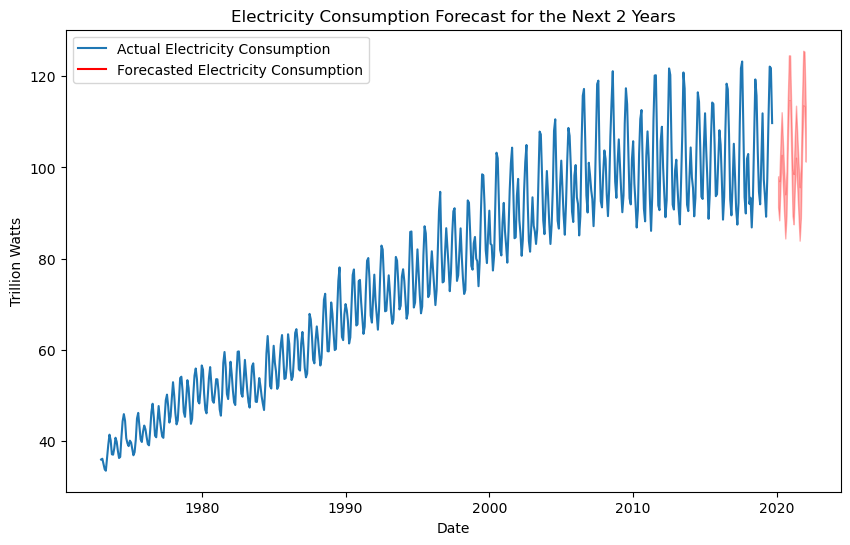

In [18]:
# plot the forecast along with the actual data
plt.figure(figsize=(10, 6))
plt.plot(ec_df['Electricty_Consumption_in_TW'], label='Actual Electricity Consumption')
plt.plot(forecast_df['Forecast'], label='Forecasted Electricity Consumption', color='red')

# plot confidence intervals
plt.fill_between(future_dates, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=0.3)
plt.title('Electricity Consumption Forecast for the Next 2 Years')
plt.xlabel('Date')
plt.ylabel('Trillion Watts')
plt.legend()
plt.show()

## Model Evaluation

In [19]:
# in-sample predictions (fitted values)
in_sample_pred = sarima.fittedvalues

# align actual data with in-sample predictions (slice the actual data to match the length of in_sample_pred)
aligned_actual = ec_df['Electricty_Consumption_in_TW'][-len(in_sample_pred):]

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(aligned_actual, in_sample_pred))
print(f'RMSE: {rmse}')

# MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

mape = mean_absolute_percentage_error(aligned_actual, in_sample_pred) * 100
print(f'MAPE: {mape}%')

# RMSPE (Root Mean Squared Percentage Error)
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

rmspe_value = rmspe(aligned_actual, in_sample_pred)
print(f'RMSPE: {rmspe_value}')

RMSE: 4.697910103395984
MAPE: 1.7188939650365442%
RMSPE: 0.02142274962906321


## Dynamic Forecasting: A Simple GUI for Dynamically Changing the Time Series Forecast

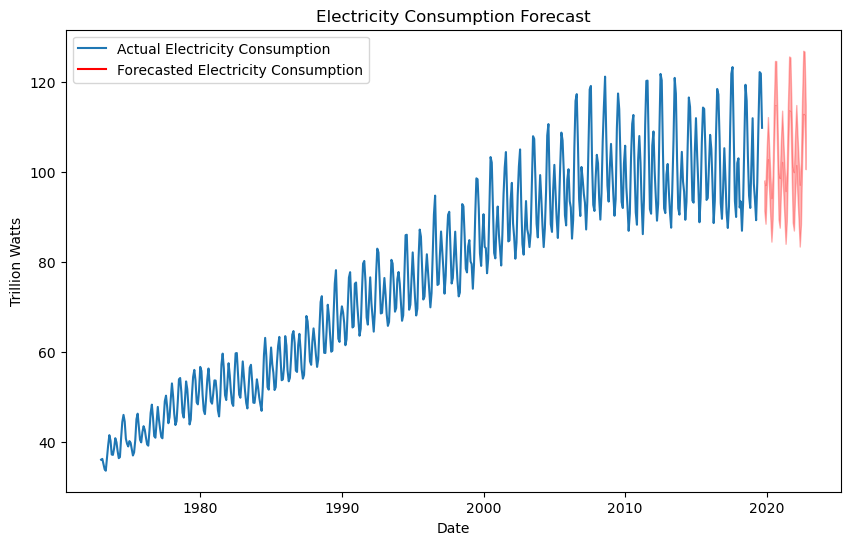

In [22]:
# create a function to update the forecast and plot
def update_forecast():
    months = int(months_entry.get())
    
    # forecast for the specified number of months
    forecast = sarima.get_forecast(steps=months)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()

    # create a future index for the forecasted values
    future_dates = pd.date_range(start=ec_df.index[-1] + pd.DateOffset(months=1), periods=months, freq='M')
    forecast_df = pd.DataFrame({'Forecast': forecast_mean}, index=future_dates)

    # clear the previous plot
    ax.clear()

    # plot the actual data and forecast
    ax.plot(ec_df['Electricty_Consumption_in_TW'], label='Actual Electricity Consumption')
    ax.plot(forecast_df['Forecast'], label='Forecasted Electricity Consumption', color='red')

    # plot confidence intervals
    ax.fill_between(future_dates, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=0.3)

    ax.set_title('Electricity Consumption Forecast')
    ax.set_xlabel('Date')
    ax.set_ylabel('Trillion Watts')
    ax.legend()

    # refresh the canvas
    canvas.draw()

# create the main window
root = tk.Tk()
root.title("Electricity Consumption Forecast")

# create and pack the input frame
input_frame = ttk.Frame(root, padding="10")
input_frame.pack(fill=tk.X)

# create and pack the label and entry for months
ttk.Label(input_frame, text="Number of months to forecast:").pack(side=tk.LEFT)
months_entry = ttk.Entry(input_frame, width=10)
months_entry.pack(side=tk.LEFT, padx=5)
months_entry.insert(0, "24")  # Default value

# create and pack the update button
update_button = ttk.Button(input_frame, text="Update Forecast", command=update_forecast)
update_button.pack(side=tk.LEFT, padx=5)

# create the matplotlib figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# create the canvas and pack it
canvas = FigureCanvasTkAgg(fig, master=root)
canvas_widget = canvas.get_tk_widget()
canvas_widget.pack(fill=tk.BOTH, expand=True)

# initial forecast update
update_forecast()

# start the GUI event loop
root.mainloop()